In [2]:
import os
import sys
sys.path.append('/scratch/users/k21066795/BreastAgeNet')
import glob
import random
import pandas as pd
import numpy as np
import openslide
from PIL import Image
import matplotlib.pyplot as plt
import scipy.stats as stats
import cv2
import json

from utils_vis import *
from utils_features import *
from utils_model import *

/scratch/users/k21066795/conda/torch-env/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/scratch/users/k21066795/conda/torch-env/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Pl

In [3]:
wsi_folder = "/scratch/prj/cb_normalbreast/prj_BreastAgeNet/WSIs/KHP_RM"
anno_folder = '/scratch/prj/cb_normalbreast/prj_BreastAgeNet/Manual_anno/KHP_lobule/geojson'
save_prefix = "/scratch/prj/cb_normalbreast/prj_BreastAgeNet/RESULTs/figures/Fig4"

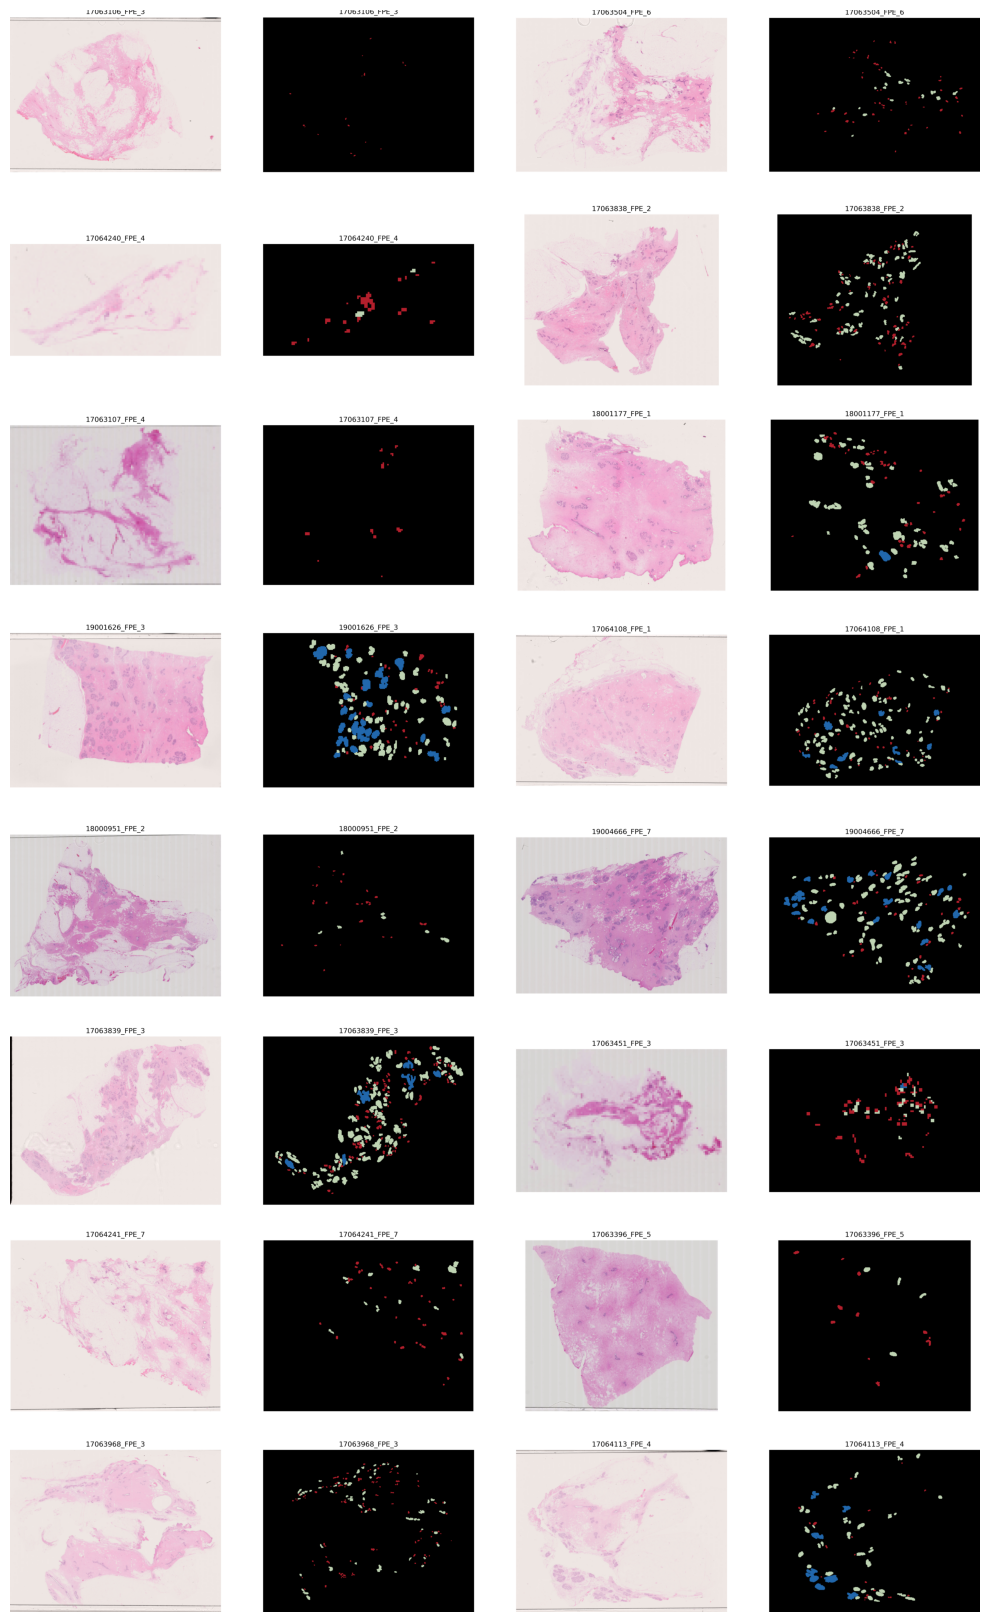

In [6]:
# # lobule type manual annotations
# imgs = []
# captions = []
# for i in os.listdir(anno_folder):
#     if '.geojson' in i:
#         wsiname = i.split('.geojson')[0]
#         anno_file = os.path.join(anno_folder, wsiname+'.geojson')
#         wsi_file = os.path.join(wsi_folder, wsiname+'.ndpi')
#         wsi=openslide.OpenSlide(wsi_file)
#         img = wsi.read_region((0,0), wsi.level_count-1, wsi.level_dimensions[wsi.level_count-1]).convert('RGB')
#         imgs.append(img)
#         captions.append(wsiname)
#         mask = lobulemask_fromAnnotation(wsi_file, anno_file)
#         # plt.imshow(mask)
#         # plt.axis('off')
#         imgs.append(mask)
#         captions.append(wsiname)
        
# save_pt = f'{save_prefix}/lobule_type_annotations.png'
# plot_multiple(img_list = imgs, caption_list = captions, grid_x = 8, grid_y = 4, figure_size = (30,50), cmap = None, save_pt=save_pt)


# img = Image.open("/cephfs/volumes/hpc_data_prj/cb_normalbreast/5bd8c988-b2ab-4eb6-b25f-6e47c2c4b969/prj_BreastAgeNet/RESULTs/figures/Fig4/lobules/lobule_type_annotations.png")
plt.figure(figsize=(10, 18))  # You can adjust the size as needed
plt.imshow(img)
plt.axis('off')
plt.tight_layout()
plt.show()

In [3]:
# QuPath quantification of lobules
dir_path = "/scratch/prj/cb_normalbreast/prj_BreastAgeNet/Manual_anno/KHP_lobule/QuPath_measures"
dfs = []
for file in os.listdir(dir_path):
    if file.endswith(".txt"):  
        file_path = os.path.join(dir_path, file)
        df = pd.read_csv(file_path, sep="\t")  
        dfs.append(df)

lobules_df = pd.concat(dfs, ignore_index=True)
lobules_df["lobule_type"] = [f"type{i}" for i in list(lobules_df["Classification"])]
lobules_df["wsi_id"] = [i.split(".ndpi")[0] for i in list(lobules_df["Image"])]

test_NR = pd.read_csv("/scratch/prj/cb_normalbreast/prj_BreastAgeNet/Metadata/test_NR_clean.csv")
lobules_df = pd.merge(lobules_df, test_NR.loc[:, ["wsi_id", "age_group"]], on="wsi_id", how="left").copy()
lobules_df.head()

Image                             Object ID Object type  \
0  19001626_FPE_3.ndpi  a7d3f37e-bae0-4e9e-b67f-9b44b57cc9a7  Annotation   
1  19001626_FPE_3.ndpi  4ed94fda-fbcb-4b46-baea-8f7fd4b33ab7  Annotation   
2  19001626_FPE_3.ndpi  89403d6c-c0c8-4c5b-bfad-7fb8f9b1d609  Annotation   
3  19001626_FPE_3.ndpi  56a0310b-ce75-4aae-924e-cfac6114dcd2  Annotation   
4  19001626_FPE_3.ndpi  b1994448-ec7b-4dff-a7f6-49787b2b58fe  Annotation   

   Name  Classification               Parent       ROI  Centroid X µm  \
0   NaN               1  Root object (Image)   Polygon        19328.0   
1   NaN               2  Root object (Image)   Polygon        27996.5   
2   NaN               2  Root object (Image)   Polygon        15337.0   
3   NaN               1  Root object (Image)   Polygon        18901.3   
4   NaN               2  Root object (Image)  Geometry        13577.3   

   Centroid Y µm  Area µm^2  Perimeter µm lobule_type          wsi_id  \
0         6683.4    22950.0        576.05       type1  19001626_FPE_3   
1        19376.0    80447.5       1053.60       type2  19001626_FPE_3   
2        17833.2   918852.4       3645.60       type2  19001626_FPE_3   
3        14723.7     6352.4        292.46       type1  19001626_FPE_3   
4        11624.8   204196.8       1761.00       type2  19001626_FPE_3   

   age_group  
0        0.0  
1        0.0  
2        0.0  
3        0.0  
4        0.0

In [4]:
# Pairwise comparison of lobule's size between lobule types (Wilcoxon rank-sum test)
save_pt = f"{save_prefix}/cluster_attention_pairwise_adj_pvalues.csv"
pval_df = compute_adjusted_pvalues(df=lobules_df, features=['Area µm^2'], group_label='lobule_type', 
                                   group_order=['type1', 'type2', 'type3'], save_pt=None)
pval_df.head()

Feature Group 1 Group 2  Adjusted p-value Significance
0  Area µm^2   type1   type2     5.221229e-183          ***
1  Area µm^2   type1   type3      3.210352e-42          ***
2  Area µm^2   type2   type3      8.389231e-35          ***

/tmp/ipykernel_291567/4199414412.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df.groupby(group_label, group_keys=False).apply(


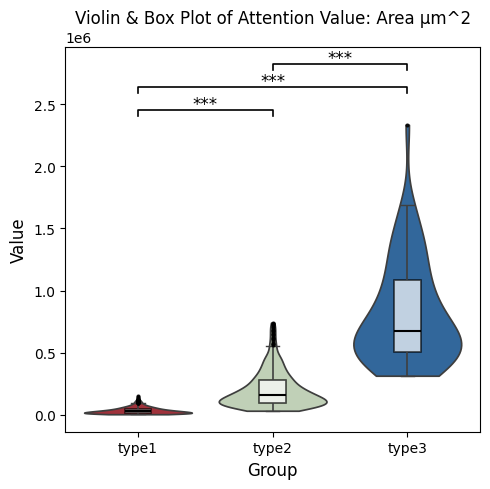

In [5]:
# Violin plot showing the pairwise comparison of lobule's size between lobule types
feature = 'Area µm^2'
group_label = 'lobule_type'
group_order = ['type1', 'type2', 'type3']
group_colors = {'type1': '#B31F2C', 'type2': '#BFD4B3', 'type3': '#2167AC'}

fig, ax = plt.subplots(figsize=(5, 5)) 
violin_boxplot_with_pvalue(lobules_df, feature, group_label, group_order, group_colors, pval_df, ax=ax)
plt.tight_layout()
save_pt = f'{save_prefix}/area_adjust_pvalues.pdf'
plt.savefig(save_pt, dpi=300, bbox_inches='tight', pad_inches=0.1, format="pdf")
plt.show()

In [11]:
# Association between lobule types and ground-truth tissue ageing ranks (Chi-square test)
contingency_table = pd.crosstab(lobules_df["age_group"], lobules_df["lobule_type"])
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
significance = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'ns'
print(f"Chi-square statistic: {chi2:.4f}")
print(f"Degrees of freedom: {dof}")
print(f"P-value: {p:.4e} {significance}")
if significance != 'ns':
    print(f"Significant association found between age_group and Pattern ({significance}).")
else:
    print("No significant association found between age_group and Pattern.")

Chi-square statistic: 156.7832
Degrees of freedom: 6
P-value: 2.8415e-31 ***
Significant association found between age_group and Pattern (***).


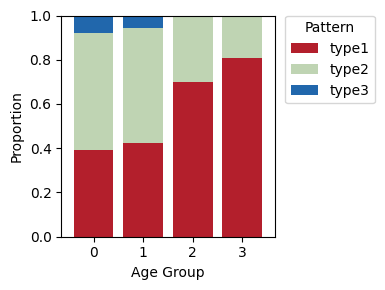

In [12]:
# Stacked barplot showing association between lobule types and ground-truth tissue ageing ranks
age_group_order = [0, 1, 2, 3]
lobule_type_order = ['type1', 'type2', 'type3']
group_colors = {'type1': '#B31F2C', 'type2': '#BFD4B3', 'type3': '#2167AC'}

counts = combined_df.groupby(["age_group", "lobule_type"]).size().unstack(fill_value=0)
proportions = counts.div(counts.sum(axis=1), axis=0)
proportions = proportions.loc[age_group_order, lobule_type_order]

fig, ax = plt.subplots(figsize=(4, 3))
proportions.plot(kind="bar", stacked=True, color=[group_colors[p] for p in lobule_type_order], ax=ax, width=0.8)
ax.set_xlabel("Age Group")
ax.set_ylabel("Proportion")
ax.set_xticklabels(age_group_order, rotation=0)
ax.set_ylim(0, 1)  
ax.legend(title="Pattern", bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()
save_pt = f'{save_prefix}/age_group_lobule_types_barplot.pdf'
plt.savefig(save_pt, dpi=300, bbox_inches='tight', pad_inches=0.1, format="pdf")
plt.show()

In [17]:
# obtain tessellated patches from lobules
patch_dir = "/scratch/prj/cb_normalbreast/prj_BreastAgeNet/Manual_anno/KHP_lobule/lobule_patches"
patch_data = []
patch_pattern = re.compile(r"([\w]+) \[d=\d+,x=(\d+),y=(\d+),w=(\d+),h=(\d+)\]\.png$")

for wsi in sorted(os.listdir(patch_dir)):  
    wsi_path = os.path.join(patch_dir, wsi)
    if os.path.isdir(wsi_path):  
        for cls in ["1", "2", "3"]:  
            cls_path = os.path.join(wsi_path, cls)
            if os.path.isdir(cls_path):  
                for patch_file in os.listdir(cls_path):  
                    if patch_file.startswith("."):
                        continue
                    patch_path = os.path.join(cls_path, patch_file)
                    match = patch_pattern.search(patch_file)
                    if match:
                        patch_id = f"{match.group(1)}_{match.group(2)}_{match.group(3)}_{match.group(4)}_{match.group(5)}"
                    else:
                        patch_id = None  # Handle unexpected filenames
                    patch_data.append({
                        "wsi_id": wsi,
                        "lobule_type": f"type{cls}",
                        "file_path": patch_path,
                        "patch_id": patch_id
                    })

patch_df = pd.DataFrame(patch_data)
save_pt = f'{save_prefix}/lobule_patches.csv'
patch_df.to_csv(save_pt, index=False)
patch_df.head()

wsi_id lobule_type  \
0  17063106_FPE_3       type1   
1  17063106_FPE_3       type1   
2  17063106_FPE_3       type1   
3  17063106_FPE_3       type1   
4  17063106_FPE_3       type1   

                                                                                                                                                        file_path  \
0   /scratch_tmp/prj/cb_normalbreast/prj_BreastAgeNet/Manual_anno/KHP_lobule/lobule_patches/17063106_FPE_3/1/17063106_FPE_3 [d=2,x=62464,y=78848,w=512,h=512].png   
1   /scratch_tmp/prj/cb_normalbreast/prj_BreastAgeNet/Manual_anno/KHP_lobule/lobule_patches/17063106_FPE_3/1/17063106_FPE_3 [d=2,x=73728,y=41984,w=512,h=512].png   
2   /scratch_tmp/prj/cb_normalbreast/prj_BreastAgeNet/Manual_anno/KHP_lobule/lobule_patches/17063106_FPE_3/1/17063106_FPE_3 [d=2,x=29184,y=78336,w=512,h=512].png   
3  /scratch_tmp/prj/cb_normalbreast/prj_BreastAgeNet/Manual_anno/KHP_lobule/lobule_patches/17063106_FPE_3/1/17063106_FPE_3 [d=2,x=67072,y=100352,w=512,h=512].png   
4   /scratch_tmp/prj/cb_normalbreast/prj_BreastAgeNet/Manual_anno/KHP_lobule/lobule_patches/17063106_FPE_3/1/17063106_FPE_3 [d=2,x=85504,y=95744,w=512,h=512].png   

                              patch_id  
0   17063106_FPE_3_62464_78848_512_512  
1   17063106_FPE_3_73728_41984_512_512  
2   17063106_FPE_3_29184_78336_512_512  
3  17063106_FPE_3_67072_100352_512_512  
4   17063106_FPE_3_85504_95744_512_512

In [16]:
# extract UNI features for tessellated lobule patches
model_name='UNI'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"device: {device}")
model, transform = get_model(model_name, device)
print(f"model_name: {model_name}")


bag_dataset = Dataset_frompatch(patch_df=patch_df, stainFunc="Reinhard", transforms_eval=transform)
batch_size = 16
num_workers = 2
fname = f'{save_prefix}/lobule_patches_reinhard_UNI_features.h5'
extract_features(model, bag_dataset, batch_size, num_workers, device, fname)

device: cuda
model_name: UNI
Total number of batches: 1118


Extracting features: 100%|██████████| 1118/1118 [36:20<00:00,  1.95s/it]


Embeddings shape: (17886, 1024)
Labels shape: (17886,)
Saved to /scratch_tmp/prj/cb_normalbreast/prj_BreastAgeNet/RESULTs/interpretation/test_NR/lobules/lobule_patches_reinhard_UNI_features.h5


In [18]:
# BreastAgeNet predictions for tessellated lobule patches
fname = f'{save_prefix}/lobule_patches_reinhard_UNI_features.h5'
with h5py.File(fname, "r") as file:
    bag = np.array(file["embeddings"])
    bag = np.squeeze(bag)
    img_id = np.array(file["patch_id"])
img_id = [i.decode("utf-8") for i in img_id]
fea_df = pd.DataFrame(bag)
fea_df.index = img_id


# load BreastAgeNet
ckpt_pt = "/scratch_tmp/prj/cb_normalbreast/prj_BreastAgeNet/RESULTs/main/train_full/epi0.9_UNI_250_MultiHeadAttention_full_best.pt"
model = load_BreastAgeNet(ckpt_pt, embed_attn=True)

phase = 'test'
model.eval()
batch_size=256
bag_size=250
wsiloader = WSI_loader(fea_df, batch_size, bag_size)
features_df = pd.DataFrame()  
for patch_ids, inputs in tqdm(wsiloader):
    patch_ids = np.array(patch_ids)
    patch_ids = np.transpose(patch_ids)
    patch_ids = patch_ids.flatten()
    with torch.set_grad_enabled(phase == 'train'):
        logits, embeddings, attentions = model(inputs)
        attentions = attentions.view(-1, attentions.shape[-1])  # Flatten attentions
        embeddings = embeddings.view(-1, embeddings.shape[-1])  # Flatten embeddings
    combined_data = np.column_stack((patch_ids, embeddings.cpu().numpy(), attentions.cpu().numpy())) 
    dfi = pd.DataFrame(combined_data, columns=['patch_id'] + [f'embedding_{i}' for i in range(embeddings.shape[1])] + [f'attention_{i}' for i in range(attentions.shape[1])]) 
    features_df = pd.concat([features_df, dfi], axis=0) 
    
lobule_patch_df = pd.merge(patch_df, features_df, on="patch_id", how="left")
save_pt = f'{save_prefix}/lobule_patches_BreastAgeNet_predictions.csv'
lobule_patch_df.to_csv(save_pt, index=False)
lobule_patch_df.head()

wsi_id lobule_type  \
0  17063106_FPE_3       type1   
1  17063106_FPE_3       type1   
2  17063106_FPE_3       type1   
3  17063106_FPE_3       type1   
4  17063106_FPE_3       type1   

                                                                                                                                                        file_path  \
0   /scratch_tmp/prj/cb_normalbreast/prj_BreastAgeNet/Manual_anno/KHP_lobule/lobule_patches/17063106_FPE_3/1/17063106_FPE_3 [d=2,x=62464,y=78848,w=512,h=512].png   
1   /scratch_tmp/prj/cb_normalbreast/prj_BreastAgeNet/Manual_anno/KHP_lobule/lobule_patches/17063106_FPE_3/1/17063106_FPE_3 [d=2,x=73728,y=41984,w=512,h=512].png   
2   /scratch_tmp/prj/cb_normalbreast/prj_BreastAgeNet/Manual_anno/KHP_lobule/lobule_patches/17063106_FPE_3/1/17063106_FPE_3 [d=2,x=29184,y=78336,w=512,h=512].png   
3  /scratch_tmp/prj/cb_normalbreast/prj_BreastAgeNet/Manual_anno/KHP_lobule/lobule_patches/17063106_FPE_3/1/17063106_FPE_3 [d=2,x=67072,y=100352,w=512,h=512].png   
4   /scratch_tmp/prj/cb_normalbreast/prj_BreastAgeNet/Manual_anno/KHP_lobule/lobule_patches/17063106_FPE_3/1/17063106_FPE_3 [d=2,x=85504,y=95744,w=512,h=512].png   

                              patch_id embedding_0 embedding_1  embedding_2  \
0   17063106_FPE_3_62464_78848_512_512  0.92178017   0.3688211  0.035960007   
1   17063106_FPE_3_73728_41984_512_512  0.47811484  0.27203214   0.19906619   
2   17063106_FPE_3_29184_78336_512_512   1.5184336   1.6895341          0.0   
3  17063106_FPE_3_67072_100352_512_512   0.9543366  0.44130272   0.54870266   
4   17063106_FPE_3_85504_95744_512_512         0.0   1.1290985          0.0   

  embedding_3 embedding_4 embedding_5  ... embedding_505 embedding_506  \
0   0.5901893         0.0         0.0  ...     1.3418592     0.5291357   
1   1.5095333  0.29287922         0.0  ...     1.8390278     0.7358835   
2  0.69975555         0.0         0.0  ...     1.7493585    0.61942077   
3         0.0         0.0         0.0  ...     1.1777802    0.76784635   
4    1.221868         0.0         0.0  ...     1.2645363    0.43688375   

  embedding_507 embedding_508 embedding_509 embedding_510 embedding_511  \
0           0.0     0.7386645           0.0     0.5527775    0.77120423   
1           0.0    0.46586466     0.5953745  0.0031492766           0.0   
2           0.0    0.78254676     0.1018922     1.1877303    0.39795363   
3    0.41375193   0.069349125     1.0469543     1.1919091           0.0   
4      0.895444    0.91644996   0.026952527           0.0     0.8702636   

    attention_0 attention_1 attention_2  
0    0.91655624  -0.8857506  -1.3203048  
1      3.412807   1.8843536  -0.8304876  
2     1.2062372  -0.2050993   1.1987066  
3  -0.053241342   -2.190241  -3.2208512  
4     1.6952025  -0.5410733  -2.8710039  

[5 rows x 519 columns]

In [ ]:
# Pairwise comparison of branch-specific attention between lobule types (Wilcoxon rank-sum test)
lobule_patch_df = pd.read_csv(f'{save_prefix}/lobule_patches_BreastAgeNet_predictions.csv')

features=["attention_0", "attention_1", "attention_2"] 
group_label = "lobule_type"
group_order = ['type1', 'type2', 'type3']
group_colors = {"type1": "#b31f2c", "type2": "#bfd4b3", "type3": "#2167ac"}

pval_df = compute_adjusted_pvalues(df=lobule_patch_df, features=["attention_0", "attention_1", "attention_2"], 
                                   group_label = "lobule_type", group_order = ['type1', 'type2', 'type3'], save_pt=None)
save_pt = f'{save_prefix}/lobule_patches_attention_adjustpvalue.csv'
pval_df.to_csv(save_pt, index=False)
print(pval_df)

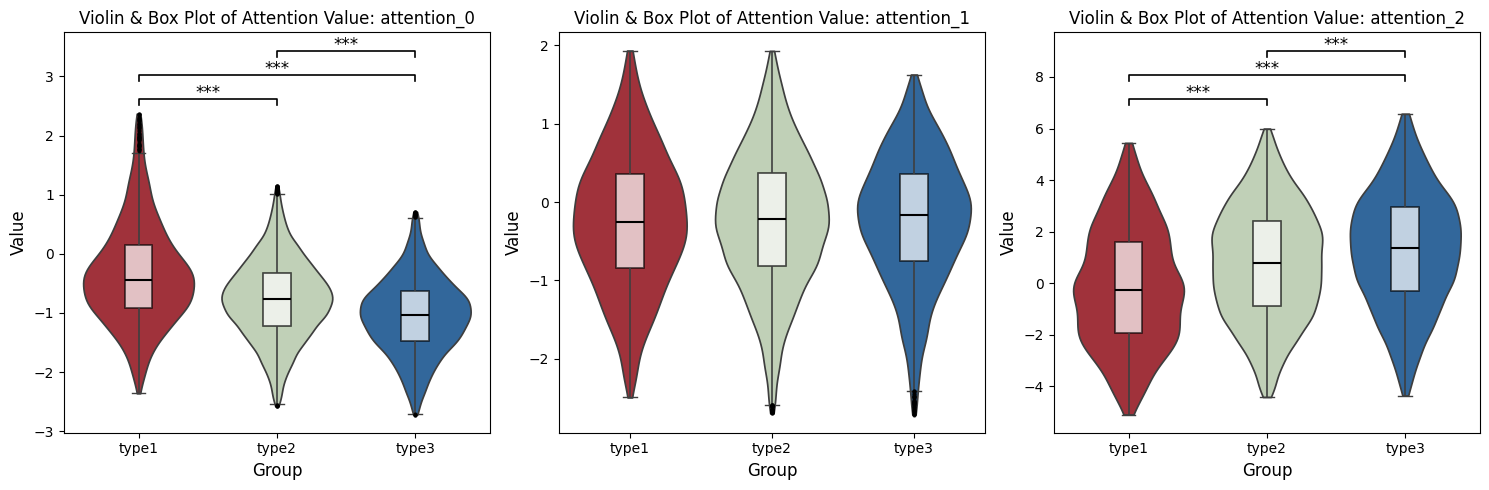

In [20]:
# Violin plot showing the pairwise comparison of branch-specific attention between lobule types
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, feature in enumerate(features):
    violin_boxplot_with_pvalue(lobule_patch_df, feature, group_label, group_order, group_colors, pval_df, ax=axes[i])

plt.tight_layout()
save_pt = f'{save_prefix}/lobule_patches_attention_adjustpvalue_violinplot.pdf'
plt.savefig(save_pt, dpi=300, bbox_inches='tight', pad_inches=0.1, format="pdf")
plt.show()

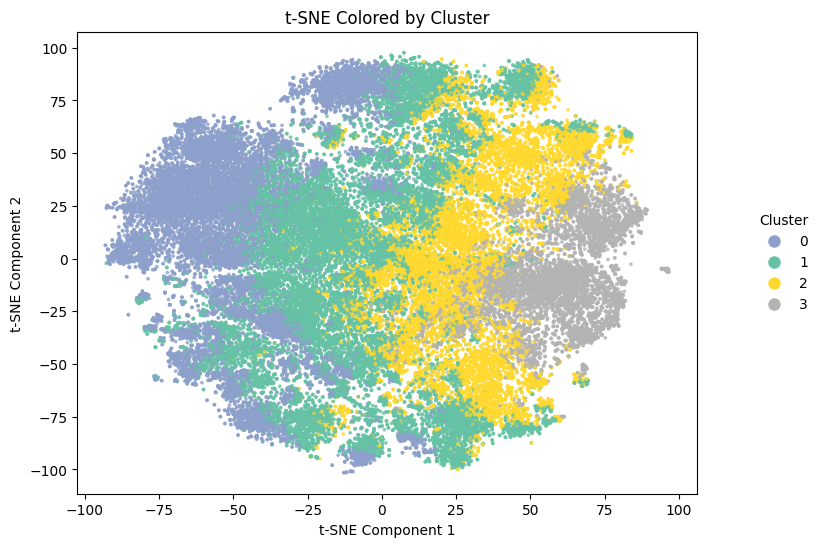

In [4]:
# a phenotype reference created from the test_NR dataset 
reference = pd.read_csv("/scratch/prj/cb_normalbreast/prj_BreastAgeNet/RESULTs/figures/Fig4/test_NR_phenotype_reference.csv")
plot_tsne(reference, color='Cluster', figsize=(8, 6), point_size=3, alpha=0.7, save_pt=None, ax=None)

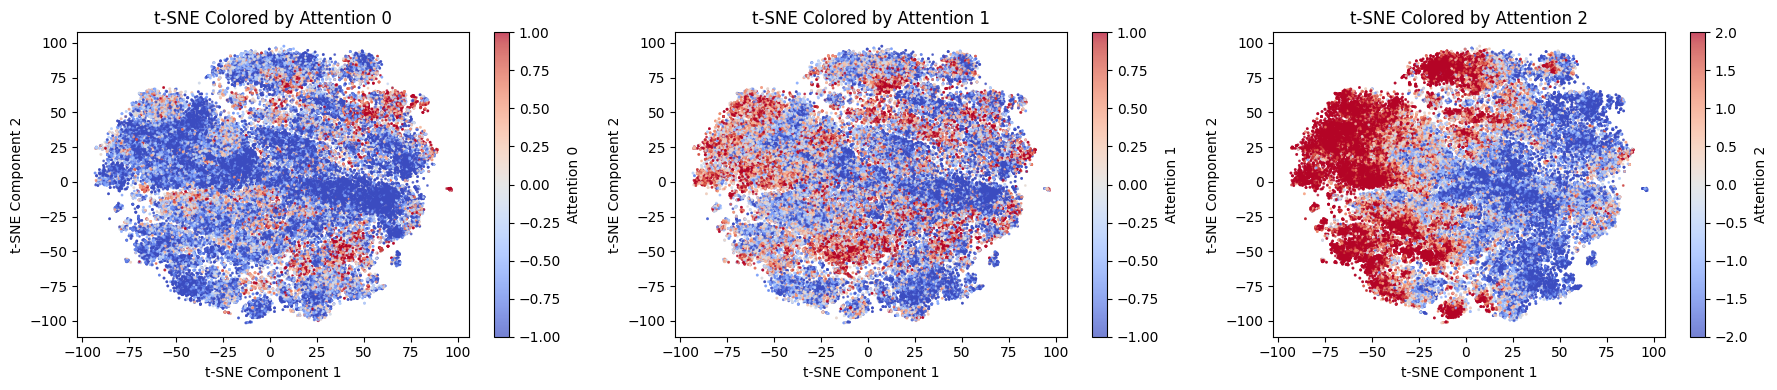

In [8]:
# branch-specific attention scores
fig, axes = plt.subplots(1, 3, figsize=(18, 4))  

plot_tsne(reference, color='attention_0', vmin=-1, vmax=1, point_size=1, ax=axes[0])
plot_tsne(reference, color='attention_1', vmin=-1, vmax=1, point_size=1, ax=axes[1])
plot_tsne(reference, color='attention_2', vmin=-2, vmax=2, point_size=1, ax=axes[2])

plt.tight_layout()
save_pt = f"{save_prefix}/test_NR_attentions_tsne.png"
plt.savefig(save_pt, dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()             

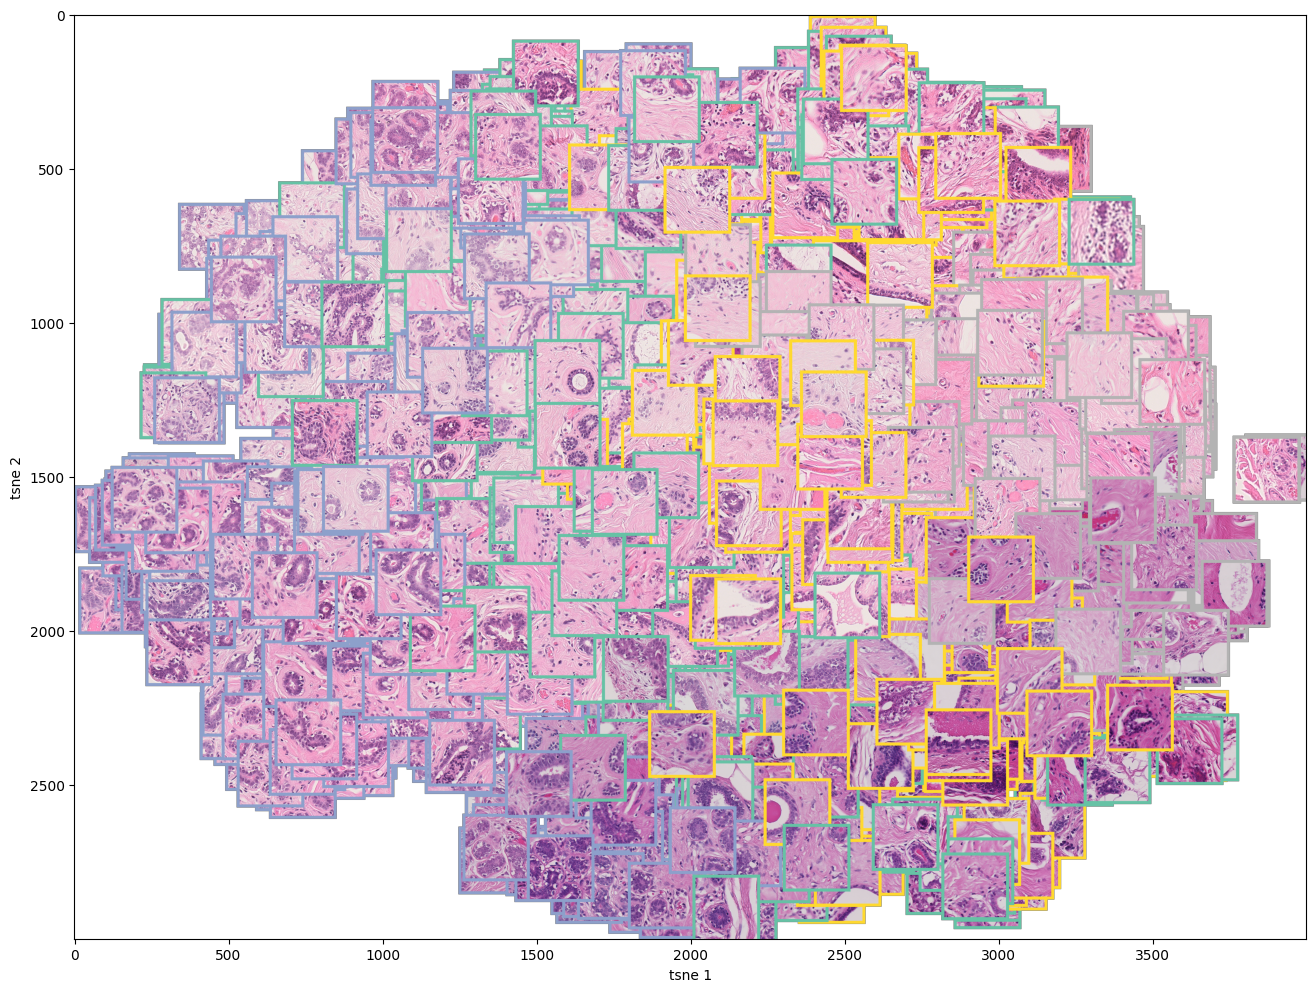

In [14]:
# histology mapping
reference.index = reference['patch_id']
cluster_colors = {0: '#8da0cb', 1: '#66c2a5', 2: '#ffd92f', 3: '#b3b3b3'}

full_image =  paste_HE_on_tsne(tsne_df=reference, WSI_folder='/scratch/prj/cb_normalbreast/prj_BreastAgeNet/WSIs',
                               cluster_colors = cluster_colors, max_dim=200, n_samples=500, 
                               image_size=(4000, 3000), random_state=42)
    
plt.figure(figsize=(16, 12))
plt.imshow(full_image)
plt.xlabel("tsne 1")
plt.ylabel("tsne 2")
# plt.gca().invert_xaxis()  # Flip the x-axis
# plt.gca().invert_yaxis()  # Flip the y-axis
plt.grid(False)
save_pt = f"{save_prefix}/test_NR_phenotype_reference_HEoverlay.png"
plt.savefig(fname=save_pt, dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [23]:
# train a Kmeans model
kmeans_model = train_kmeans(reference, n_clusters=4)

In [24]:
# predict ageing phenotypes
lobule_patch_df = apply_kmeans(lobule_patch_df, reference, kmeans_model)
lobule_patch_df["Pattern"] = [f"P{i}" for i in list(lobule_patch_df["Cluster"])]
lobule_patch_df

Label Mapping: {3: 0, 0: 1, 1: 2, 2: 3}


wsi_id lobule_type  \
0      17063106_FPE_3       type1   
1      17063106_FPE_3       type1   
2      17063106_FPE_3       type1   
3      17063106_FPE_3       type1   
4      17063106_FPE_3       type1   
...               ...         ...   
17881  19004666_FPE_7       type3   
17882  19004666_FPE_7       type3   
17883  19004666_FPE_7       type3   
17884  19004666_FPE_7       type3   
17885  19004666_FPE_7       type3   

                                                                                                                                                            file_path  \
0       /scratch_tmp/prj/cb_normalbreast/prj_BreastAgeNet/Manual_anno/KHP_lobule/lobule_patches/17063106_FPE_3/1/17063106_FPE_3 [d=2,x=62464,y=78848,w=512,h=512].png   
1       /scratch_tmp/prj/cb_normalbreast/prj_BreastAgeNet/Manual_anno/KHP_lobule/lobule_patches/17063106_FPE_3/1/17063106_FPE_3 [d=2,x=73728,y=41984,w=512,h=512].png   
2       /scratch_tmp/prj/cb_normalbreast/prj_BreastAgeNet/Manual_anno/KHP_lobule/lobule_patches/17063106_FPE_3/1/17063106_FPE_3 [d=2,x=29184,y=78336,w=512,h=512].png   
3      /scratch_tmp/prj/cb_normalbreast/prj_BreastAgeNet/Manual_anno/KHP_lobule/lobule_patches/17063106_FPE_3/1/17063106_FPE_3 [d=2,x=67072,y=100352,w=512,h=512].png   
4       /scratch_tmp/prj/cb_normalbreast/prj_BreastAgeNet/Manual_anno/KHP_lobule/lobule_patches/17063106_FPE_3/1/17063106_FPE_3 [d=2,x=85504,y=95744,w=512,h=512].png   
...                                                                                                                                                               ...   
17881  /scratch_tmp/prj/cb_normalbreast/prj_BreastAgeNet/Manual_anno/KHP_lobule/lobule_patches/19004666_FPE_7/3/19004666_FPE_7 [d=2,x=113152,y=44032,w=512,h=512].png   
17882   /scratch_tmp/prj/cb_normalbreast/prj_BreastAgeNet/Manual_anno/KHP_lobule/lobule_patches/19004666_FPE_7/3/19004666_FPE_7 [d=2,x=14848,y=40960,w=512,h=512].png   
17883  /scratch_tmp/prj/cb_normalbreast/prj_BreastAgeNet/Manual_anno/KHP_lobule/lobule_patches/19004666_FPE_7/3/19004666_FPE_7 [d=2,x=101888,y=33792,w=512,h=512].png   
17884   /scratch_tmp/prj/cb_normalbreast/prj_BreastAgeNet/Manual_anno/KHP_lobule/lobule_patches/19004666_FPE_7/3/19004666_FPE_7 [d=2,x=69632,y=37376,w=512,h=512].png   
17885   /scratch_tmp/prj/cb_normalbreast/prj_BreastAgeNet/Manual_anno/KHP_lobule/lobule_patches/19004666_FPE_7/3/19004666_FPE_7 [d=2,x=91648,y=77824,w=512,h=512].png   

                                  patch_id  embedding_0  embedding_1  \
0       17063106_FPE_3_62464_78848_512_512     0.921780     0.368821   
1       17063106_FPE_3_73728_41984_512_512     0.478115     0.272032   
2       17063106_FPE_3_29184_78336_512_512     1.518434     1.689534   
3      17063106_FPE_3_67072_100352_512_512     0.954337     0.441303   
4       17063106_FPE_3_85504_95744_512_512     0.000000     1.129099   
...                                    ...          ...          ...   
17881  19004666_FPE_7_113152_44032_512_512     1.631923     0.145404   
17882   19004666_FPE_7_14848_40960_512_512     2.704252     0.280025   
17883  19004666_FPE_7_101888_33792_512_512     2.287772     0.000000   
17884   19004666_FPE_7_69632_37376_512_512     2.227261     0.331445   
17885   19004666_FPE_7_91648_77824_512_512     3.170338     0.099748   

       embedding_2  embedding_3  embedding_4  embedding_5  ...  embedding_507  \
0         0.035960     0.590189     0.000000     0.000000  ...       0.000000   
1         0.199066     1.509533     0.292879     0.000000  ...       0.000000   
2         0.000000     0.699756     0.000000     0.000000  ...       0.000000   
3         0.548703     0.000000     0.000000     0.000000  ...       0.413752   
4         0.000000     1.221868     0.000000     0.000000  ...       0.895444   
...            ...          ...          ...          ...  ...            ...   
17881     0.058571     0.170777     0.000000     0.259941  ...       1.637736   
17882     0.000000     0.000

In [25]:
# Association between lobule types and ageing phenotypes (Chi-square test)
contingency_table = pd.crosstab(lobule_patch_df["Pattern"], lobule_patch_df["lobule_type"])
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
significance = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'ns'
print(f"Chi-square statistic: {chi2:.4f}")
print(f"Degrees of freedom: {dof}")
print(f"P-value: {p:.4e} {significance}")
if significance != 'ns':
    print(f"Significant association found between age_group and Pattern ({significance}).")
else:
    print("No significant association found between age_group and Pattern.")

Chi-square statistic: 887.8624
Degrees of freedom: 6
P-value: 1.5801e-188 ***
Significant association found between age_group and Pattern (***).


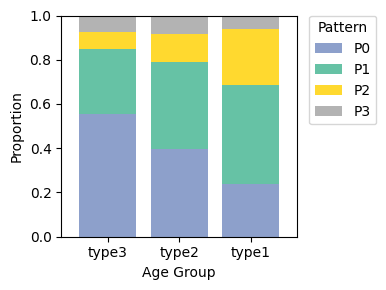

In [26]:
# Stacked barplot showing association between lobule types and ageing phenotypes (Chi-square test)
age_pattern_order = ['P0', 'P1', 'P2', 'P3']
lobule_type_order = ['type3', 'type2', 'type1']
pattern_colors = {'P0': '#8da0cb', 'P1': '#66c2a5', 'P2': '#ffd92f', 'P3': '#b3b3b3'}

counts = lobule_patch_df.groupby(["lobule_type", "Pattern"]).size().unstack(fill_value=0)
proportions = counts.div(counts.sum(axis=1), axis=0)
proportions = proportions.loc[lobule_type_order, age_pattern_order]

fig, ax = plt.subplots(figsize=(4, 3))
proportions.plot(kind="bar", stacked=True, color=[pattern_colors[p] for p in age_pattern_order], ax=ax, width=0.8)
ax.set_xlabel("Age Group")
ax.set_ylabel("Proportion")
ax.set_xticklabels(lobule_type_order, rotation=0)
ax.set_ylim(0, 1)  
ax.legend(title="Pattern", bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()
save_pt = f'{save_prefix}/age_group_lobule_types_stackedbarplot.pdf'
plt.savefig(save_pt, dpi=300, bbox_inches='tight', pad_inches=0.1, format="pdf")
plt.show()

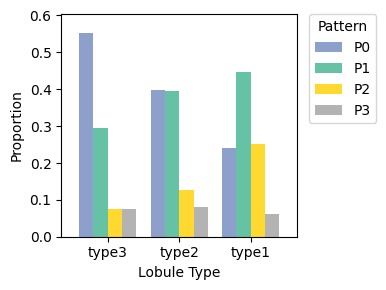

In [27]:
# Barplot showing association between lobule types and ageing phenotypes (Chi-square test)
age_pattern_order = ['P0', 'P1', 'P2', 'P3']
lobule_type_order = ['type3', 'type2', 'type1']
pattern_colors = {'P0': '#8da0cb', 'P1': '#66c2a5', 'P2': '#ffd92f', 'P3': '#b3b3b3'}

counts = lobule_patch_df.groupby(["lobule_type", "Pattern"]).size().unstack(fill_value=0)
proportions = counts.div(counts.sum(axis=1), axis=0)
proportions = proportions.loc[lobule_type_order, age_pattern_order]

fig, ax = plt.subplots(figsize=(4, 3))
proportions.plot(kind="bar", stacked=False, color=[pattern_colors[p] for p in age_pattern_order], ax=ax, width=0.8)
ax.set_xlabel("Lobule Type")
ax.set_ylabel("Proportion")
ax.set_xticklabels(lobule_type_order, rotation=0)
ax.set_ylim(0, proportions.max().max() + 0.05)  # Adds a small margin above the highest bar
ax.legend(title="Pattern", bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)

plt.tight_layout()
save_pt = f'{save_prefix}/age_group_lobule_types_barplot.pdf'
plt.savefig(save_pt, dpi=300, bbox_inches='tight', pad_inches=0.1, format="pdf")
plt.show()

/scratch/users/k21066795/conda/torch-env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


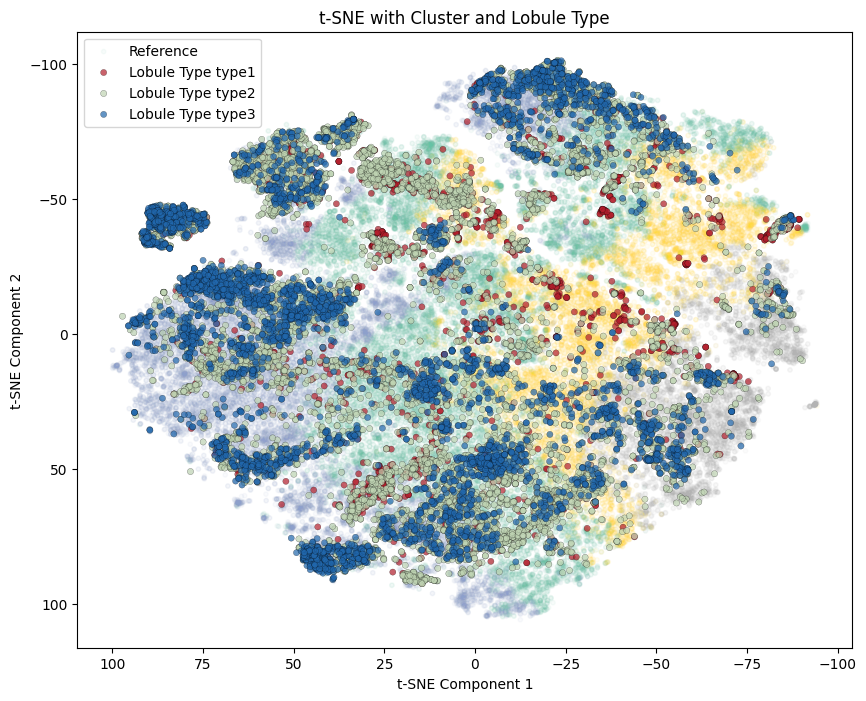

In [28]:
cluster_colors = {0: '#8da0cb', 1: '#66c2a5', 2: '#ffd92f', 3: '#b3b3b3'}
save_pt = f'{save_prefix}/NR_KHP_reference_lobule_types_tsne_ageing_phenotypes_mapping.png'
lobule_patch_df, reference  = highlight_a_WSI_in_tsne(lobule_patch_df, reference, cluster_colors, save_pt)

Label Mapping: {3: 0, 0: 1, 1: 2, 2: 3}


/scratch/users/k21066795/conda/torch-env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


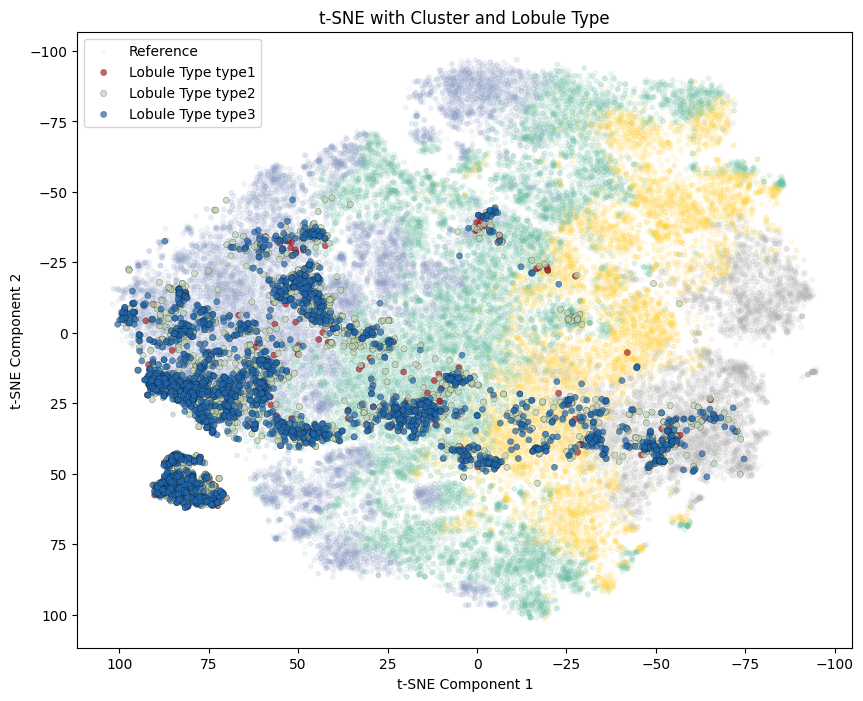

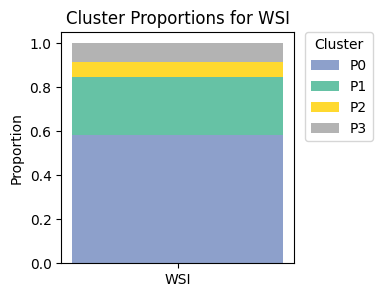

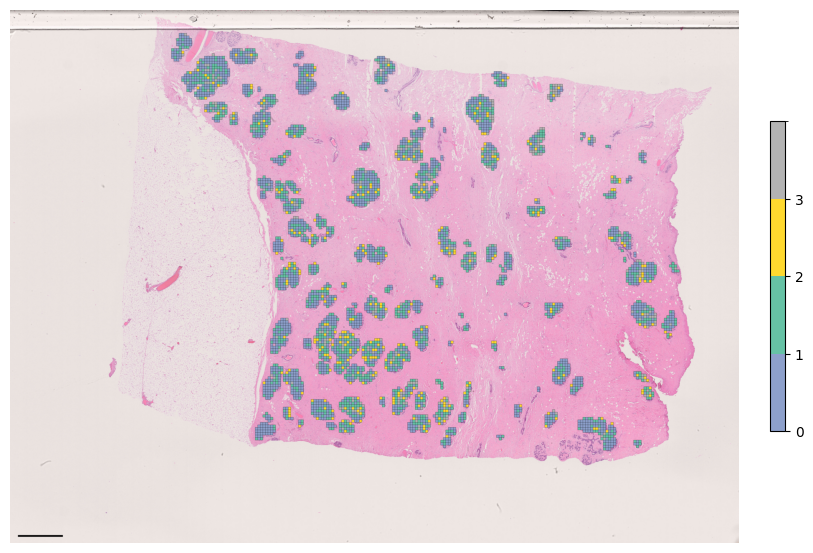

/scratch/prj/cb_normalbreast/prj_BreastAgeNet/RESULTs/figures/Fig4/19001626_FPE_3_BreastAgeNet_clusters.json saved!


In [29]:
# predict ageing phenotypes for a single WSI
wsi_id = "19001626_FPE_3"
new_df = lobule_patch_df.loc[lobule_patch_df['wsi_id'] == wsi_id, :].copy()
new_df = apply_kmeans(new_df, reference, kmeans_model)

# visualise the WSI in reference tsne
save_pt = f'{save_prefix}/{wsi_id}_highlights_on_tsne.png'
cluster_colors = {0: '#8da0cb', 1: '#66c2a5', 2: '#ffd92f', 3: '#b3b3b3'}
new_df, reference  = highlight_a_WSI_in_tsne(new_df, reference, cluster_colors, save_pt=save_pt)

# show cluster proportions of the WSI
save_pt = f'{save_prefix}/{wsi_id}_clusters_proportion_barplot.pdf'
plot_cluster_proportion_for_a_WSI(new_df, save_pt=save_pt, normalize=True)

# overlay clusters on the WSI
new_df["patch_size"] = [int(i.split("_")[-1]) for i in new_df["patch_id"]]
new_df["x_orig"] = [int(i.split("_")[-4]) for i in new_df["patch_id"]]
new_df["y_orig"] = [int(i.split("_")[-3]) for i in new_df["patch_id"]]
new_df = new_df.loc[new_df["patch_size"] == 512, :].copy()

wsi_path = glob.glob(f"/scratch/prj/cb_normalbreast/prj_BreastAgeNet/WSIs/*/19001626_FPE_3*.*")[0]
save_pt = f'{save_prefix}/{wsi_id}_clusters_overlayon_WSI.png'
new_df, wsi_img = draw_wsi_with_clusters(new_df, wsi_path, cluster_colors, level=5, save_pt=save_pt)

# export QuPath JSON file
clusters_json_for_a_WSI(new_df, wsi_id, cluster_colors, 
                        json_dir=save_prefix, require_bounds=False)